In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from TA2HRR2021 import mirage_analysis, PKG_DATA

from TA2HRR2021.image_analysis import Image_proc
from TA2HRR2021.paths import DATA_FOLDER, CAL_DATA

from TA2HRR2021.general_tools import choose_cal_file, glob_path, save_object, load_object, get_file_path, calc_COW
from scipy.ndimage import median_filter
from TA2HRR2021.image_analysis import Image_proc

import pathlib
from pathlib import Path
DATA_PATH = Path(DATA_FOLDER)
git_pkg_data_path = Path(r'/home/ms13901/GitHub/TA2HRR2021/TA2HRR2021/pkg_data')




mirage_analysis.configure(DATA_FOLDER)
# CAL_DATA = PKG_DATA






from TA2HRR2021.general_tools import d, calc_COW, mad, generate_simplex, Read_SQL_shot_summary, get_file_shot_number

from TA2HRR2021.beam_fitting import fitBeam, gauss2Dbeam_img, gauss2Dbeam


analysis_path = Path('/data/analysis/GEMINI/2021/App20110001-1/Palmer2021/ANALYSIS_files/')

sql_reader = Read_SQL_shot_summary()

run_list = set(sql_reader.get_run_names())
run_list = sorted([x for x in run_list if 'run' in x])

my_fontsize = 14

diag = 'ProtonSpatial'

# ellispse plotting
theta = np.linspace(0,2*np.pi,2000)
a = 25
b = 25
phi = 0*np.pi/180
x_dash = a*np.sin(theta)
y_dash = b*np.cos(theta)
x_e = x_dash*np.cos(phi)-y_dash*np.sin(phi)-2
y_e = x_dash*np.sin(phi)+y_dash*np.cos(phi)

20210608/run03


<ipython-input-11-912ac2dc4264>:58: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[0].pcolormesh(x_mm,y_mm, img_sum, vmax=np.percentile(img_sum,80)) #,vmax=0.5,vmin=0)
<ipython-input-11-912ac2dc4264>:59: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs[1].pcolormesh(x_mm, y_mm, img_sum*screen_mask, vmax=np.percentile(img_sum,80))
<ipython-input-11-912ac2dc4264>:60: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is

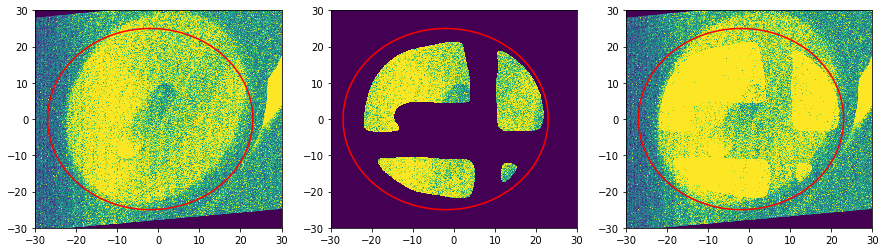

In [11]:
#Maintain list of done runs.  Try to add in new runs in order for easy checking
run_name_list = ['20210608/run03']#,'20210610/run03','20210611/run05','20210617/run14','20210617/run15','20210617/run19','20210729/run14','20210729/run05', '20210729/run07','20210729/run09',   '20210803/run08']
#No calibration for:
#'20210603/run06','20210610/run03','20210611/run05','20210518/run15'

#problem list
#'20210620/run22',

#done list:
# run_name_list = ['20210617/run04','20210618/run05',]

for run_name in run_name_list:
    print(run_name)
    run_name_cal = run_name
   



    #get the shot info from the database
    shot_info = sql_reader.get_run(run_name)
#     shot_info.head()

    #load calibration for dewarping of proton spatial
    tForm_filepath = choose_cal_file(run_name_cal,1,diag,diag+'_transform',cal_data_path=PKG_DATA)

    # load a screen mask cased on run date - this is for the transformed image.
    screen_mask_file  = choose_cal_file(run_name,1,diag,diag+'_screen_mask',cal_data_path=PKG_DATA)
    mask_data = load_object(screen_mask_file)
    screen_mask = mask_data['screen_mask']

    pSpatial_proc = Image_proc(tForm_filepath)
    x_mm = pSpatial_proc.screen_x_mm
    y_mm = pSpatial_proc.screen_y_mm

    img_sum = np.zeros_like(screen_mask)
    for b,N_s in zip(shot_info['shot_or_burst'],shot_info['burst_length']):
        if N_s is None:
            b=None
        elif not np.isfinite(N_s):
            b=None
        # load in the run of images and sum to get an idea of screen position
        file_paths = get_file_path(diag,run_name, b)
        s_num_list = [get_file_shot_number(f) for f in file_paths]

        for count, file_path in enumerate(file_paths):
            #load and dewarp the images and create an array of images from one burst

            img_temp = pSpatial_proc.file2screen(file_path)
          #  print(type(img_temp))
            img_sum = img_sum + img_temp


   
    # Display image, screen mask for that date and overlay to check with a 25 mm radius circle.  Due to shadowing of the screen by the mount, the screen can appear to not be a circle or be offset even if the mask is good.  Confirm the filters are aligned to check that analysis will be accurate.
    img_comb = cv2.addWeighted(img_sum, 1, img_sum*screen_mask, 0.8,  0, dtype = cv2.CV_32F)

    fig,axs = plt.subplots(1,3,figsize=(15,4))
    axs[0].pcolormesh(x_mm,y_mm, img_sum, vmax=np.percentile(img_sum,80)) #,vmax=0.5,vmin=0)
    axs[1].pcolormesh(x_mm, y_mm, img_sum*screen_mask, vmax=np.percentile(img_sum,80))
    axs[2].pcolormesh(x_mm, y_mm, img_comb, vmax=np.percentile(img_sum,80))
    axs[0].plot(x_e,y_e,'r-')
    axs[1].plot(x_e,y_e,'r-')
    axs[2].plot(x_e,y_e,'r-')

    #create directory for saving files
    run_str = run_name.replace('/','_')
    new_directory = '//mnt/ceph/analysisdata/GEMINI/2021/App20110001-1/Palmer2021/ANALYSIS_files/ProtonSpatial_Analysis/' + run_name + '/SupportingFiles'
    pathlib.Path(new_directory).mkdir(parents = True, exist_ok=True)
    plt.savefig(f'{new_directory}/pSpatial_ScreenMaskOverlay_{run_str}.png',dpi=300)

    plt.show()
    plt.close()

In [ ]:
# Display image, screen mask for that date and overlay to check with a 25 mm radius circle.  Due to shadowing of the screen by the mount, the screen can appear to not be a circle or be offset even if the mask is good.  Confirm the filters are aligned to check that analysis will be accurate.
img_comb = cv2.addWeighted(img_sum, 1,img_sum*screen_mask, 0.8,  0, dtype = cv2.CV_32F)

fig,axs = plt.subplots(1,3,figsize=(15,4))

axs[0].pcolormesh(x_mm,y_mm, img_sum, vmax=np.percentile(img_sum,80)) #,vmax=0.5,vmin=0)
axs[1].pcolormesh(x_mm, y_mm, img_sum*screen_mask, vmax=np.percentile(img_sum,80))
axs[2].pcolormesh(x_mm, y_mm, img_comb, vmax=np.percentile(img_sum,80))


axs[0].plot(x_e,y_e,'r-')
axs[1].plot(x_e,y_e,'r-')
axs[2].plot(x_e,y_e,'r-')

#create directory for saving files
run_str = run_name.replace('/','_')
new_directory = '//mnt/ceph/analysisdata/GEMINI/2021/App20110001-1/Palmer2021/ANALYSIS_files/ProtonSpatial_Analysis/' + run_name + '/SupportingFiles'
pathlib.Path(new_directory).mkdir(parents = True, exist_ok=True)
plt.savefig(f'{new_directory}/pSpatial_ScreenMaskOverlay_{run_str}.png',dpi=300)

plt.show()